In [5]:
import numpy as np
import cc3d

def dice_score(gt, pred):
    intersection = np.sum((gt > 0) & (pred > 0))
    size_gt = np.sum(gt > 0)
    size_pred = np.sum(pred > 0)
    if size_gt + size_pred == 0:
        return 1.0
    return 2.0 * intersection / (size_gt + size_pred)

# def calculate_fp_fn(gt, pred):
#     fp = np.sum((gt == 0) & (pred == 1))
#     fn = np.sum((gt == 1) & (pred == 0))
#     return fp, fn

def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp


def false_pos_pix(gt_array,pred_array):
    # compute number of voxels of false positive connected components in prediction mask
    pred_conn_comp = con_comp(pred_array)
    
    false_pos = 0
    for idx in range(1,pred_conn_comp.max()+1):
        comp_mask = np.isin(pred_conn_comp, idx)
        if (comp_mask*gt_array).sum() == 0:
            false_pos = false_pos+comp_mask.sum()
    return false_pos



def false_neg_pix(gt_array,pred_array):
    # compute number of voxels of false negative connected components (of the ground truth mask) in the prediction mask
    gt_conn_comp = con_comp(gt_array)
    
    false_neg = 0
    for idx in range(1,gt_conn_comp.max()+1):
        comp_mask = np.isin(gt_conn_comp, idx)
        if (comp_mask*pred_array).sum() == 0:
            false_neg = false_neg+comp_mask.sum()
            
    return false_neg

def calculate_fp_fn(gt, pred):
    return false_pos_pix(gt, pred), false_neg_pix(gt, pred)

In [31]:
import os

# dir_path = "nnUNet_outputs/Dataset221_AutoPETII_2023_test"
# dir_path = "nnUNet_outputs_reconstructed/Dataset500_MIP_Segmentation_test"
# dir_path = "nnUNet_outputs_reconstructed/Dataset501_Synthetic_MIP_Segmentation_test"
# dir_path = "nnUNet_outputs/Dataset700_PET_CT_Recon_test"
# dir_path = "nnUNet_outputs/Dataset701_PET_CT_Recon_Synthetic"
# dir_path = "nnUNet_outputs/Dataset800_PET_CT_TrueRecon_test"
dir_path = "nnUNet_outputs_reconstructed/ground_truth_mips_1"
samples = os.listdir(dir_path)
samples = [file for file in samples if file.endswith(".nii.gz")]

In [32]:
samples[0], len(samples)

('PETCT_9aa97cf103_07-18-2004-NA-PET-CT Ganzkoerper  primaer mit KM-81345.nii.gz',
 202)

In [33]:
import nibabel as nib
from tqdm import tqdm

records = []
for sample in tqdm(samples):
    label = nib.load(f"nnUNet_raw/Dataset600_PET_CT_Recon/labelsTs/{sample}")
    prediction = nib.load(f"{dir_path}/{sample}")
    assert label.shape == prediction.shape
    image_label = np.array(label.dataobj)
    image_prediction = np.array(prediction.dataobj)
    pixdim = label.header['pixdim']
    voxel_volume = pixdim[1] * pixdim[2] * pixdim[3] / 1000
    score = dice_score(image_label, image_prediction)
    fp, fn = calculate_fp_fn(image_label, image_prediction)
    # print(fp, fn, pixdim)
    fpv, fnv = fp * voxel_volume, fn * voxel_volume
    records.append({
        "sample": sample,
        "dice_score": score,
        "fpv": fpv,
        "fnv": fnv,
        "label_sum": image_label.sum(),
        "prediction_sum": image_prediction.sum(),
        "voxel_volume": voxel_volume,
    })
    print(records[-1])

  0%|▏                                          | 1/202 [00:10<36:38, 10.94s/it]

{'sample': 'PETCT_9aa97cf103_07-18-2004-NA-PET-CT Ganzkoerper  primaer mit KM-81345.nii.gz', 'dice_score': 0.8791269973832192, 'fpv': 0.6842561531066894, 'fnv': 0.012441020965576172, 'label_sum': 24110, 'prediction_sum': 29773, 'voxel_volume': 0.012441020965576172}


  1%|▍                                          | 2/202 [00:11<15:33,  4.67s/it]

{'sample': 'PETCT_098c4b7b87_08-31-2003-NA-PET-CT Ganzkoerper nativ-71743.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  1%|▋                                          | 3/202 [00:11<08:47,  2.65s/it]

{'sample': 'PETCT_402c061122_08-25-2003-NA-PET-CT Ganzkoerper nativ-22953.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  2%|▊                                          | 4/202 [00:12<06:02,  1.83s/it]

{'sample': 'PETCT_9a66a81ad1_10-31-2004-NA-PET-CT Ganzkoerper nativ-04122.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  2%|█                                          | 5/202 [00:12<04:27,  1.36s/it]

{'sample': 'PETCT_fc0389a486_05-30-2005-NA-PET-CT Ganzkoerper  primaer mit KM-25868.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  3%|█▎                                         | 6/202 [00:12<03:14,  1.01it/s]

{'sample': 'PETCT_81debf13a1_03-09-2006-NA-PET-CT Ganzkoerper  primaer mit KM-10303.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  3%|█▍                                         | 7/202 [00:13<02:44,  1.19it/s]

{'sample': 'PETCT_30e2b83b74_04-26-2003-NA-PET-CT Ganzkoerper  primaer mit KM-85741.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  4%|█▋                                         | 8/202 [00:14<02:32,  1.27it/s]

{'sample': 'PETCT_f4668d2bdc_09-04-2000-NA-PET-CT Ganzkoerper  primaer mit KM-84583.nii.gz', 'dice_score': 0.9497067265693249, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 3874, 'prediction_sum': 4139, 'voxel_volume': 0.012441020965576172}


  4%|█▉                                         | 9/202 [00:16<04:40,  1.45s/it]

{'sample': 'PETCT_448225c237_01-16-2006-NA-PET-CT Ganzkoerper  primaer mit KM-96439.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0.0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  5%|██                                        | 10/202 [00:17<03:29,  1.09s/it]

{'sample': 'PETCT_f603eeceba_03-17-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29929.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  5%|██▎                                       | 11/202 [00:17<03:03,  1.04it/s]

{'sample': 'PETCT_de118d7ab9_06-02-2001-NA-PET-CT Ganzkoerper  primaer mit KM-18077.nii.gz', 'dice_score': 0.9304088816680206, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1769, 'prediction_sum': 1924, 'voxel_volume': 0.012441020965576172}


  6%|██▍                                       | 12/202 [00:21<05:22,  1.70s/it]

{'sample': 'PETCT_119165872d_02-12-2005-NA-PET-CT Ganzkoerper  primaer mit KM-05102.nii.gz', 'dice_score': 0.917028338013786, 'fpv': 0.0, 'fnv': 0.012441020965576172, 'label_sum': 1944, 'prediction_sum': 1973, 'voxel_volume': 0.012441020965576172}


  6%|██▋                                       | 13/202 [00:21<03:57,  1.26s/it]

{'sample': 'PETCT_90d668ed29_06-07-2003-NA-PET-CT Ganzkoerper  primaer mit KM-12980.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  7%|██▉                                       | 14/202 [00:25<06:13,  1.98s/it]

{'sample': 'PETCT_b899150306_08-11-2002-NA-PET-CT Ganzkoerper  primaer mit KM-26543.nii.gz', 'dice_score': 0.9099052091486216, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 10764, 'prediction_sum': 12234, 'voxel_volume': 0.012441020965576172}


  7%|███                                       | 15/202 [00:25<04:47,  1.54s/it]

{'sample': 'PETCT_30e2b83b74_07-21-2003-NA-PET-CT Ganzkoerper nativ-81120.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  8%|███▎                                      | 16/202 [00:38<15:13,  4.91s/it]

{'sample': 'PETCT_b509ace2a2_05-27-2002-NA-PET-CT Ganzkoerper  primaer mit KM-84477.nii.gz', 'dice_score': 0.9046609352712133, 'fpv': 0.04976408386230469, 'fnv': 0.07464612579345703, 'label_sum': 12174, 'prediction_sum': 13765, 'voxel_volume': 0.012441020965576172}


  8%|███▌                                      | 17/202 [00:38<11:03,  3.58s/it]

{'sample': 'PETCT_fde79b6aa9_08-16-2003-NA-PET-CT Ganzkoerper  primaer mit KM-88178.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  9%|███▋                                      | 18/202 [00:39<08:11,  2.67s/it]

{'sample': 'PETCT_6f46454a8d_09-07-2003-NA-PET-CT Ganzkoerper  primaer mit KM-17255.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


  9%|███▉                                      | 19/202 [00:39<05:56,  1.95s/it]

{'sample': 'PETCT_9f491f1481_02-12-2006-NA-PET-CT Ganzkoerper  primaer mit KM-19458.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 10%|████▏                                     | 20/202 [00:40<04:43,  1.56s/it]

{'sample': 'PETCT_3c3050f75e_09-05-2002-NA-PET-CT Ganzkoerper  primaer mit KM-31873.nii.gz', 'dice_score': 0.9353233830845771, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 205, 'prediction_sum': 197, 'voxel_volume': 0.012441020965576172}


 10%|████▎                                     | 21/202 [00:40<03:35,  1.19s/it]

{'sample': 'PETCT_d0ea6c975f_10-11-2002-NA-PET-CT Ganzkoerper  primaer mit KM-09558.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 11%|████▌                                     | 22/202 [00:56<17:08,  5.71s/it]

{'sample': 'PETCT_6c469107a0_06-23-2002-NA-PET-CT Ganzkoerper  primaer mit KM-84161.nii.gz', 'dice_score': 0.9301527783318042, 'fpv': 0.0, 'fnv': 0.037323062896728515, 'label_sum': 24114, 'prediction_sum': 26024, 'voxel_volume': 0.012441020965576172}


 11%|████▊                                     | 23/202 [00:58<12:58,  4.35s/it]

{'sample': 'PETCT_a1db71e797_03-25-2005-NA-PET-CT Ganzkoerper  primaer mit KM-62987.nii.gz', 'dice_score': 0.9323479249573622, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 869, 'prediction_sum': 890, 'voxel_volume': 0.012441020965576172}


 12%|████▉                                     | 24/202 [00:59<10:16,  3.46s/it]

{'sample': 'PETCT_f9e0c504af_06-29-2003-NA-PET-CT Ganzkoerper  primaer mit KM-14170.nii.gz', 'dice_score': 0.9562460367786937, 'fpv': 0.0, 'fnv': 0.012441020965576172, 'label_sum': 1586, 'prediction_sum': 1568, 'voxel_volume': 0.012441020965576172}


 12%|█████▏                                    | 25/202 [01:09<15:39,  5.31s/it]

{'sample': 'PETCT_7948aa0e26_08-10-2001-NA-PET-CT Ganzkoerper  primaer mit KM-23662.nii.gz', 'dice_score': 0.9352119763492264, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 15450, 'prediction_sum': 16346, 'voxel_volume': 0.012441020965576172}


 13%|█████▍                                    | 26/202 [01:10<11:46,  4.01s/it]

{'sample': 'PETCT_7785c10e91_12-15-2006-NA-PET-CT Ganzkoerper  primaer mit KM-36884.nii.gz', 'dice_score': 0.0, 'fpv': 0.0, 'fnv': 4.205065086364746, 'label_sum': 338, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 13%|█████▌                                    | 27/202 [01:13<11:05,  3.80s/it]

{'sample': 'PETCT_8de6953d23_01-19-2001-NA-PET-CT Ganzkoerper  primaer mit KM-85501.nii.gz', 'dice_score': 0.9064537448868406, 'fpv': 0.07464612579345703, 'fnv': 0.012441020965576172, 'label_sum': 25647, 'prediction_sum': 30336, 'voxel_volume': 0.012441020965576172}


 14%|█████▊                                    | 28/202 [01:14<08:34,  2.96s/it]

{'sample': 'PETCT_ebb0045704_09-27-2002-NA-Unspecified CT-08213.nii.gz', 'dice_score': 0.9327428402716268, 'fpv': 0.0, 'fnv': 0.04976408386230469, 'label_sum': 7977, 'prediction_sum': 8958, 'voxel_volume': 0.012441020965576172}


 14%|██████                                    | 29/202 [01:14<06:11,  2.15s/it]

{'sample': 'PETCT_855c7fca12_07-27-2006-NA-PET-CT Ganzkoerper  primaer mit KM-14836.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 15%|██████▏                                   | 30/202 [01:15<04:38,  1.62s/it]

{'sample': 'PETCT_a2676f03c0_05-09-2003-NA-PET-CT Ganzkoerper  primaer mit KM-90793.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 15%|██████▍                                   | 31/202 [01:15<03:27,  1.21s/it]

{'sample': 'PETCT_f15b868db6_02-03-2006-NA-PET-CT Ganzkoerper  primaer mit KM-17521.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 16%|██████▋                                   | 32/202 [01:15<02:50,  1.00s/it]

{'sample': 'PETCT_1e43e3d692_09-19-2002-NA-PET-CT Ganzkoerper  primaer mit KM-73301.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 16%|██████▊                                   | 33/202 [01:16<02:12,  1.27it/s]

{'sample': 'PETCT_9a83943958_08-03-2003-NA-PET-CT Ganzkoerper  primaer mit KM-73758.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 17%|███████                                   | 34/202 [01:19<04:31,  1.62s/it]

{'sample': 'PETCT_65a1330e90_06-16-2001-NA-PET-CT Ganzkoerper  primaer mit KM-34748.nii.gz', 'dice_score': 0.944628382235415, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 8530, 'prediction_sum': 8988, 'voxel_volume': 0.012441020965576172}


 17%|███████▎                                  | 35/202 [01:19<03:23,  1.22s/it]

{'sample': 'PETCT_75d1080946_07-28-2003-NA-PET-CT Ganzkoerper  primaer mit KM-72389.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 18%|███████▍                                  | 36/202 [01:23<05:27,  1.97s/it]

{'sample': 'PETCT_c58477f3b4_12-07-2002-NA-PET-CT Ganzkoerper  primaer mit KM-71683.nii.gz', 'dice_score': 0.9384073911130665, 'fpv': 0.0, 'fnv': 0.06220510482788086, 'label_sum': 2331, 'prediction_sum': 2215, 'voxel_volume': 0.012441020965576172}


 18%|███████▋                                  | 37/202 [01:27<07:01,  2.56s/it]

{'sample': 'PETCT_bd7c02faa9_05-04-2002-NA-PET-CT Ganzkoerper  primaer mit KM-25841.nii.gz', 'dice_score': 0.9225443530938987, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 10937, 'prediction_sum': 12173, 'voxel_volume': 0.012441020965576172}


 19%|███████▉                                  | 38/202 [01:54<26:49,  9.82s/it]

{'sample': 'PETCT_a82f03863a_03-19-2007-NA-PET-CT Ganzkoerper  primaer mit KM-75117.nii.gz', 'dice_score': 0.9055395325708603, 'fpv': 0.0, 'fnv': 11.89361604309082, 'label_sum': 24852, 'prediction_sum': 25423, 'voxel_volume': 0.012441020965576172}


 19%|████████                                  | 39/202 [02:00<23:42,  8.73s/it]

{'sample': 'PETCT_0beb67c923_07-25-1999-NA-PET-CT Ganzkoerper  primaer mit KM-37911.nii.gz', 'dice_score': 0.8747490536833555, 'fpv': 0.11196918869018554, 'fnv': 0.0, 'label_sum': 57385, 'prediction_sum': 73121, 'voxel_volume': 0.012441020965576172}


 20%|████████▎                                 | 40/202 [02:00<16:43,  6.19s/it]

{'sample': 'PETCT_3b14690fce_09-07-2002-NA-PET-CT Ganzkoerper  primaer mit KM-38312.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 20%|████████▌                                 | 41/202 [02:01<11:51,  4.42s/it]

{'sample': 'PETCT_ce629e2993_01-13-2005-NA-PET-CT Ganzkoerper  primaer mit KM-38727.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 21%|████████▋                                 | 42/202 [02:01<08:25,  3.16s/it]

{'sample': 'PETCT_ae4dcc5dd3_10-08-2004-NA-PET-CT Teilkoerper  primaer mit KM-60181.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 21%|████████▉                                 | 43/202 [02:04<08:22,  3.16s/it]

{'sample': 'PETCT_ab1fa26e5e_06-23-2001-NA-PET-CT Ganzkoerper  primaer mit KM-50764.nii.gz', 'dice_score': 0.9347360694843722, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 7914, 'prediction_sum': 8435, 'voxel_volume': 0.012441020965576172}


 22%|█████████▏                                | 44/202 [02:04<06:03,  2.30s/it]

{'sample': 'PETCT_3481507253_06-17-2007-NA-PET-CT Ganzkoerper  primaer mit KM-41462.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 22%|█████████▎                                | 45/202 [02:05<04:29,  1.72s/it]

{'sample': 'PETCT_c32e1daf9b_02-02-2003-NA-PET-CT Ganzkoerper  primaer mit KM-73090.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 23%|█████████▌                                | 46/202 [02:05<03:17,  1.27s/it]

{'sample': 'PETCT_c2ffda4725_09-19-2003-NA-PET-CT Teilkoerper  primaer mit KM-27018.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 23%|█████████▊                                | 47/202 [02:08<04:47,  1.85s/it]

{'sample': 'PETCT_88bcc970b3_02-28-2002-NA-PET-CT Ganzkoerper  primaer mit KM-41395.nii.gz', 'dice_score': 0.9546807308344321, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 38271, 'prediction_sum': 41364, 'voxel_volume': 0.012441020965576172}


 24%|█████████▉                                | 48/202 [02:10<04:52,  1.90s/it]

{'sample': 'PETCT_6d6a193655_11-17-2002-NA-PET-CT Ganzkoerper  primaer mit KM-45963.nii.gz', 'dice_score': 0.9552963529846413, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 9190, 'prediction_sum': 9757, 'voxel_volume': 0.012441020965576172}


 24%|██████████▏                               | 49/202 [02:11<04:08,  1.62s/it]

{'sample': 'PETCT_e61c9da258_12-13-2002-NA-PET-CT Ganzkoerper  primaer mit KM-78457.nii.gz', 'dice_score': 0.9088526063511084, 'fpv': 0.0, 'fnv': 0.024882041931152343, 'label_sum': 12281, 'prediction_sum': 14423, 'voxel_volume': 0.012441020965576172}


 25%|██████████▍                               | 50/202 [02:27<15:18,  6.04s/it]

{'sample': 'PETCT_dac5cd2a4d_12-02-2001-NA-PET-CT Ganzkoerper  primaer mit KM-27614.nii.gz', 'dice_score': 0.9175589300981151, 'fpv': 0.2239383773803711, 'fnv': 0.06220510482788086, 'label_sum': 23115, 'prediction_sum': 26011, 'voxel_volume': 0.012441020965576172}


 25%|██████████▌                               | 51/202 [02:31<13:06,  5.21s/it]

{'sample': 'PETCT_d3d61785e6_10-19-2001-NA-PET-CT Ganzkoerper  primaer mit KM-35929.nii.gz', 'dice_score': 0.9284792756444841, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 20045, 'prediction_sum': 22586, 'voxel_volume': 0.012441020965576172}


 26%|██████████▊                               | 52/202 [02:31<09:18,  3.72s/it]

{'sample': 'PETCT_d6b2218bf3_12-18-2004-NA-PET-CT Ganzkoerper  primaer mit KM-87440.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 26%|███████████                               | 53/202 [02:31<06:48,  2.74s/it]

{'sample': 'PETCT_4a72eeb991_12-23-2005-NA-PET-CT Ganzkoerper  primaer mit KM-76289.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 27%|███████████▏                              | 54/202 [02:36<08:25,  3.41s/it]

{'sample': 'PETCT_1253499c80_10-07-2005-NA-PET-CT Ganzkoerper  primaer mit KM-50242.nii.gz', 'dice_score': 0.9605939463163906, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 3467, 'prediction_sum': 3537, 'voxel_volume': 0.012441020965576172}


 27%|███████████▍                              | 55/202 [02:37<06:02,  2.46s/it]

{'sample': 'PETCT_e1a5b05186_02-27-2005-NA-PET-CT Ganzkoerper  primaer mit KM-36173.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 28%|███████████▋                              | 56/202 [02:41<07:04,  2.91s/it]

{'sample': 'PETCT_89065bc4ab_02-20-2004-NA-PET-CT Ganzkoerper  primaer mit KM-11843.nii.gz', 'dice_score': 0.8611111111111112, 'fpv': 0.0, 'fnv': 0.012441020965576172, 'label_sum': 200, 'prediction_sum': 160, 'voxel_volume': 0.012441020965576172}


 28%|███████████▊                              | 57/202 [02:41<05:07,  2.12s/it]

{'sample': 'PETCT_0e9a98ecda_02-20-2003-NA-PET-CT Ganzkoerper  primaer mit KM-36915.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 29%|████████████                              | 58/202 [02:41<03:42,  1.55s/it]

{'sample': 'PETCT_ca5406d339_12-09-2004-NA-PET-CT Teilkoerper  primaer mit KM-57041.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 29%|████████████▎                             | 59/202 [02:41<02:45,  1.16s/it]

{'sample': 'PETCT_e5e1918765_07-24-2003-NA-PET-CT Ganzkoerper  primaer mit KM-69923.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 30%|████████████▍                             | 60/202 [02:42<02:38,  1.12s/it]

{'sample': 'PETCT_41472f5ce9_03-16-2003-NA-PET-CT Ganzkoerper  primaer mit KM-95962.nii.gz', 'dice_score': 0.9065485788549013, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 19003, 'prediction_sum': 22548, 'voxel_volume': 0.012441020965576172}


 30%|████████████▋                             | 61/202 [02:48<05:53,  2.50s/it]

{'sample': 'PETCT_527c5afc5d_07-18-2003-NA-PET-CT Ganzkoerper  primaer mit KM-02474.nii.gz', 'dice_score': 0.9428014981273408, 'fpv': 0.012441020965576172, 'fnv': 0.037323062896728515, 'label_sum': 16158, 'prediction_sum': 17217, 'voxel_volume': 0.012441020965576172}


 31%|████████████▉                             | 62/202 [02:53<07:47,  3.34s/it]

{'sample': 'PETCT_47cd731006_01-25-2002-NA-PET-CT Ganzkoerper  primaer mit KM-31216.nii.gz', 'dice_score': 0.8857067090957306, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 13634, 'prediction_sum': 16534, 'voxel_volume': 0.012441020965576172}


 31%|█████████████                             | 63/202 [02:54<05:36,  2.42s/it]

{'sample': 'PETCT_dc3437c9b9_11-21-2002-NA-PET-CT Ganzkoerper  primaer mit KM-60759.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 32%|█████████████▎                            | 64/202 [02:56<05:10,  2.25s/it]

{'sample': 'PETCT_ca89066e44_08-11-2005-NA-PET-CT Ganzkoerper  primaer mit KM-64009.nii.gz', 'dice_score': 0.9054866151564817, 'fpv': 0.0, 'fnv': 0.024882041931152343, 'label_sum': 5950, 'prediction_sum': 6863, 'voxel_volume': 0.012441020965576172}


 32%|█████████████▌                            | 65/202 [02:56<03:47,  1.66s/it]

{'sample': 'PETCT_a57bd6b006_11-09-2002-NA-PET-CT Ganzkoerper  primaer mit KM-13048.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 33%|█████████████▋                            | 66/202 [02:56<02:49,  1.25s/it]

{'sample': 'PETCT_bef465b4ad_05-04-2007-NA-PET-CT Ganzkoerper  primaer mit KM-73031.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 33%|█████████████▉                            | 67/202 [02:57<02:53,  1.29s/it]

{'sample': 'PETCT_2e97a9e5c2_06-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-00442.nii.gz', 'dice_score': 0.9438730531883632, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1692, 'prediction_sum': 1711, 'voxel_volume': 0.012441020965576172}


 34%|██████████████▏                           | 68/202 [03:01<04:07,  1.85s/it]

{'sample': 'PETCT_5e0bc6cdda_10-27-2001-NA-PET-CT Ganzkoerper  primaer mit KM-75350.nii.gz', 'dice_score': 0.8743233548555404, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 6985, 'prediction_sum': 8348, 'voxel_volume': 0.012441020965576172}


 34%|██████████████▎                           | 69/202 [03:02<03:50,  1.73s/it]

{'sample': 'PETCT_af73b85f2c_06-19-2003-NA-PET-CT Ganzkoerper  primaer mit KM-19562.nii.gz', 'dice_score': 0.9529438001784122, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 4325, 'prediction_sum': 4643, 'voxel_volume': 0.012441020965576172}


 35%|██████████████▌                           | 70/202 [03:03<03:11,  1.45s/it]

{'sample': 'PETCT_20995a0fe1_12-02-2005-NA-PET-CT Ganzkoerper nativ-92555.nii.gz', 'dice_score': 0.9574803149606299, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 650, 'prediction_sum': 620, 'voxel_volume': 0.012441020965576172}


 35%|██████████████▊                           | 71/202 [03:03<02:33,  1.17s/it]

{'sample': 'PETCT_a933c9af60_09-19-2002-NA-PET-CT Ganzkoerper nativ-00786.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 36%|██████████████▉                           | 72/202 [03:13<08:18,  3.84s/it]

{'sample': 'PETCT_4848bebb10_02-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-17214.nii.gz', 'dice_score': 0.8452470133659268, 'fpv': 0.19905633544921875, 'fnv': 0.0870871467590332, 'label_sum': 21811, 'prediction_sum': 28915, 'voxel_volume': 0.012441020965576172}


 36%|███████████████▏                          | 73/202 [03:16<07:05,  3.30s/it]

{'sample': 'PETCT_e79291780d_05-14-2007-NA-PET-CT Ganzkoerper  primaer mit KM-72066.nii.gz', 'dice_score': 0.8959537572254336, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 180, 'prediction_sum': 166, 'voxel_volume': 0.012441020965576172}


 37%|███████████████▍                          | 74/202 [03:16<05:05,  2.39s/it]

{'sample': 'PETCT_e4e99dbb47_07-17-2005-NA-PET-CT Ganzkoerper  primaer mit KM-52196.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 37%|███████████████▌                          | 75/202 [03:16<03:52,  1.83s/it]

{'sample': 'PETCT_55d55902c6_05-11-2006-NA-PET-CT Ganzkoerper  primaer mit KM-26216.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 38%|███████████████▊                          | 76/202 [03:19<04:23,  2.09s/it]

{'sample': 'PETCT_979f9c3dba_06-22-2006-NA-PET-CT Ganzkoerper  primaer mit KM-59545.nii.gz', 'dice_score': 0.9576820434616851, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1319, 'prediction_sum': 1304, 'voxel_volume': 0.012441020965576172}


 38%|████████████████                          | 77/202 [03:21<04:18,  2.07s/it]

{'sample': 'PETCT_14c4d2c208_09-22-2002-NA-PET-CT Ganzkoerper  primaer mit KM-60478.nii.gz', 'dice_score': 0.9379975874547648, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 2042, 'prediction_sum': 2103, 'voxel_volume': 0.012441020965576172}


 39%|████████████████▏                         | 78/202 [03:21<03:09,  1.53s/it]

{'sample': 'PETCT_7ee7610b9e_01-21-2006-NA-PET-CT Ganzkoerper  primaer mit KM-58977.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 39%|████████████████▍                         | 79/202 [03:23<03:15,  1.59s/it]

{'sample': 'PETCT_f01e83894d_03-24-2005-NA-PET-CT Ganzkoerper  primaer mit KM-61290.nii.gz', 'dice_score': 0.9482535575679172, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 781, 'prediction_sum': 765, 'voxel_volume': 0.012441020965576172}


 40%|████████████████▋                         | 80/202 [03:25<03:46,  1.86s/it]

{'sample': 'PETCT_760c77b289_01-20-2002-NA-PET-CT Ganzkoerper  primaer mit KM-00579.nii.gz', 'dice_score': 0.9656797459276714, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 4866, 'prediction_sum': 4895, 'voxel_volume': 0.012441020965576172}


 40%|████████████████▊                         | 81/202 [03:26<02:48,  1.39s/it]

{'sample': 'PETCT_a41d59682f_09-29-2006-NA-PET-CT Ganzkoerper  primaer mit KM-76863.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 41%|█████████████████                         | 82/202 [03:27<02:39,  1.33s/it]

{'sample': 'PETCT_62b114e09b_03-27-2003-NA-PET-CT Ganzkoerper  primaer mit KM-71302.nii.gz', 'dice_score': 0.9271781534460338, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1487, 'prediction_sum': 1589, 'voxel_volume': 0.012441020965576172}


 41%|█████████████████▎                        | 83/202 [03:58<20:29, 10.33s/it]

{'sample': 'PETCT_ad7cd4a9d2_10-02-2003-NA-Unspecified CT ABDOMEN-67897.nii.gz', 'dice_score': 0.8390592939443363, 'fpv': 1.6422147674560548, 'fnv': 2.239383773803711, 'label_sum': 72837, 'prediction_sum': 98226, 'voxel_volume': 0.012441020965576172}


 42%|█████████████████▍                        | 84/202 [04:07<19:04,  9.70s/it]

{'sample': 'PETCT_c16d325d12_02-15-2003-NA-PET-CT Ganzkoerper  primaer mit KM-77095.nii.gz', 'dice_score': 0.9139130434782609, 'fpv': 0.0, 'fnv': 0.012441020965576172, 'label_sum': 11848, 'prediction_sum': 13452, 'voxel_volume': 0.012441020965576172}


 42%|█████████████████▋                        | 85/202 [04:07<13:24,  6.87s/it]

{'sample': 'PETCT_3f3df20439_05-09-2005-NA-PET-CT Ganzkoerper  primaer mit KM-26210.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 43%|█████████████████▉                        | 86/202 [04:07<09:28,  4.90s/it]

{'sample': 'PETCT_69ee62b035_12-26-2002-NA-PET-CT Ganzkoerper  primaer mit KM-42071.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 43%|██████████████████                        | 87/202 [04:07<06:43,  3.51s/it]

{'sample': 'PETCT_595975bc57_03-10-2006-NA-PET-CT Ganzkoerper  primaer mit KM-47727.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 44%|██████████████████▎                       | 88/202 [04:08<04:50,  2.55s/it]

{'sample': 'PETCT_402c061122_02-22-2003-NA-PET-CT Ganzkoerper nativ-88656.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 44%|██████████████████▌                       | 89/202 [04:08<03:31,  1.87s/it]

{'sample': 'PETCT_bbb2df1e31_01-29-2005-NA-PET-CT Ganzkoerper  primaer mit KM-90674.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 45%|██████████████████▋                       | 90/202 [04:08<02:33,  1.37s/it]

{'sample': 'PETCT_c2ffda4725_04-11-2003-NA-PET-CT Teilkoerper  primaer mit KM-94251.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 45%|██████████████████▉                       | 91/202 [04:08<01:56,  1.05s/it]

{'sample': 'PETCT_a3ce52b2a8_11-15-2003-NA-PET-CT Ganzkoerper  primaer mit KM-48149.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 46%|███████████████████▏                      | 92/202 [04:09<01:36,  1.14it/s]

{'sample': 'PETCT_71ac560ffe_03-19-2007-NA-PET-CT Ganzkoerper  primaer mit KM-20185.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 46%|███████████████████▎                      | 93/202 [04:26<10:30,  5.78s/it]

{'sample': 'PETCT_5d10be5b89_05-30-2005-NA-PET-CT Ganzkoerper  primaer mit KM-53829.nii.gz', 'dice_score': 0.8632583001175034, 'fpv': 0.42299471282958984, 'fnv': 0.19905633544921875, 'label_sum': 38153, 'prediction_sum': 48653, 'voxel_volume': 0.012441020965576172}


 47%|███████████████████▌                      | 94/202 [04:26<07:26,  4.13s/it]

{'sample': 'PETCT_d31a5688a2_09-21-2003-NA-PET-CT Ganzkoerper  primaer mit KM-27218.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 47%|███████████████████▊                      | 95/202 [04:27<05:18,  2.97s/it]

{'sample': 'PETCT_53ccb9efbb_12-15-2005-NA-PET-CT Ganzkoerper  primaer mit KM-33641.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 48%|███████████████████▉                      | 96/202 [04:30<05:10,  2.93s/it]

{'sample': 'PETCT_62405d117c_03-11-2001-NA-PET-CT Ganzkoerper  primaer mit KM-26235.nii.gz', 'dice_score': 0.9120175438596492, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 10552, 'prediction_sum': 12248, 'voxel_volume': 0.012441020965576172}


 48%|████████████████████▏                     | 97/202 [04:30<03:44,  2.14s/it]

{'sample': 'PETCT_2922971d0f_07-19-2003-NA-PET-CT Ganzkoerper  primaer mit KM-78645.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 49%|████████████████████▍                     | 98/202 [04:31<02:56,  1.69s/it]

{'sample': 'PETCT_d674a028b1_12-03-2001-NA-PET-CT Ganzkoerper  primaer mit KM-18993.nii.gz', 'dice_score': 0.9302325581395349, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 109, 'prediction_sum': 106, 'voxel_volume': 0.012441020965576172}


 49%|████████████████████▌                     | 99/202 [04:31<02:18,  1.35s/it]

{'sample': 'PETCT_6f46454a8d_09-12-2002-NA-PET-CT Ganzkoerper  primaer mit KM-14772.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 50%|████████████████████▎                    | 100/202 [04:32<02:12,  1.30s/it]

{'sample': 'PETCT_1a1712f7d0_02-14-2005-NA-PET-CT Ganzkoerper  primaer mit KM-78148.nii.gz', 'dice_score': 0.9421265141318977, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1112, 'prediction_sum': 1117, 'voxel_volume': 0.012441020965576172}


 50%|████████████████████▌                    | 101/202 [04:36<03:30,  2.08s/it]

{'sample': 'PETCT_185da4c8b6_04-18-2003-NA-PET-CT Ganzkoerper  primaer mit KM-06919.nii.gz', 'dice_score': 0.8830814961605152, 'fpv': 0.012441020965576172, 'fnv': 0.037323062896728515, 'label_sum': 3741, 'prediction_sum': 4333, 'voxel_volume': 0.012441020965576172}


 50%|████████████████████▋                    | 102/202 [04:43<05:40,  3.40s/it]

{'sample': 'PETCT_9521502dbb_05-17-2007-NA-PET-CT Ganzkoerper  primaer mit KM-42207.nii.gz', 'dice_score': 0.7834542367649329, 'fpv': 0.0, 'fnv': 13.448743663787841, 'label_sum': 3754, 'prediction_sum': 2725, 'voxel_volume': 0.012441020965576172}


 51%|████████████████████▉                    | 103/202 [04:47<05:59,  3.63s/it]

{'sample': 'PETCT_46ee4ddd68_03-19-2007-NA-PET-CT Ganzkoerper  primaer mit KM-86763.nii.gz', 'dice_score': 0.8995215311004785, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 877, 'prediction_sum': 795, 'voxel_volume': 0.012441020965576172}


 51%|█████████████████████                    | 104/202 [04:48<04:50,  2.96s/it]

{'sample': 'PETCT_b52920038c_06-07-2003-NA-PET-CT Ganzkoerper  primaer mit KM-50621.nii.gz', 'dice_score': 0.9015354618571777, 'fpv': 0.04976408386230469, 'fnv': 0.0, 'label_sum': 18685, 'prediction_sum': 22345, 'voxel_volume': 0.012441020965576172}


 52%|█████████████████████▎                   | 105/202 [04:51<04:31,  2.80s/it]

{'sample': 'PETCT_1a1712f7d0_07-05-2001-NA-PET-CT Ganzkoerper  primaer mit KM-51804.nii.gz', 'dice_score': 0.9471231403477326, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 5421, 'prediction_sum': 5737, 'voxel_volume': 0.012441020965576172}


 52%|█████████████████████▌                   | 106/202 [04:52<03:44,  2.34s/it]

{'sample': 'PETCT_2a6f4f0753_07-31-2003-NA-PET-CT Ganzkoerper  primaer mit KM-21938.nii.gz', 'dice_score': 0.891566265060241, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 46, 'prediction_sum': 37, 'voxel_volume': 0.012441020965576172}


 53%|█████████████████████▋                   | 107/202 [04:52<02:42,  1.71s/it]

{'sample': 'PETCT_d472033d3b_09-28-2002-NA-PET-CT Ganzkoerper nativ-51450.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 53%|█████████████████████▉                   | 108/202 [04:53<02:30,  1.60s/it]

{'sample': 'PETCT_f637b5930b_07-27-2003-NA-PET-CT Ganzkoerper nativ u. mit KM-06338.nii.gz', 'dice_score': 0.0, 'fpv': 0.0, 'fnv': 1.7541839561462402, 'label_sum': 141, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 54%|██████████████████████                   | 109/202 [04:55<02:34,  1.66s/it]

{'sample': 'PETCT_556b56485a_08-29-2003-NA-PET-CT Ganzkoerper  primaer mit KM-83019.nii.gz', 'dice_score': 0.9535575858250277, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 13885, 'prediction_sum': 15011, 'voxel_volume': 0.012441020965576172}


 54%|██████████████████████▎                  | 110/202 [04:58<03:04,  2.01s/it]

{'sample': 'PETCT_b1219c408b_10-04-2002-NA-PET-CT Ganzkoerper  primaer mit KM-34572.nii.gz', 'dice_score': 0.9361854791694695, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 10660, 'prediction_sum': 11639, 'voxel_volume': 0.012441020965576172}


 55%|██████████████████████▌                  | 111/202 [04:58<02:15,  1.49s/it]

{'sample': 'PETCT_93132553f6_08-12-2002-NA-PET-CT Ganzkoerper  primaer mit KM-51100.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 55%|██████████████████████▋                  | 112/202 [04:59<01:42,  1.14s/it]

{'sample': 'PETCT_38733c001e_07-28-2006-NA-PET-CT Ganzkoerper  primaer mit KM-05310.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 56%|██████████████████████▉                  | 113/202 [04:59<01:16,  1.16it/s]

{'sample': 'PETCT_e9feb1135e_07-01-2005-NA-PET-CT Ganzkoerper  primaer mit KM-42484.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 56%|███████████████████████▏                 | 114/202 [05:02<02:02,  1.40s/it]

{'sample': 'PETCT_01140d52d8_08-13-2005-NA-PET-CT Ganzkoerper  primaer mit KM-56839.nii.gz', 'dice_score': 0.942280881122781, 'fpv': 0.0, 'fnv': 0.024882041931152343, 'label_sum': 15383, 'prediction_sum': 16894, 'voxel_volume': 0.012441020965576172}


 57%|███████████████████████▎                 | 115/202 [05:05<02:56,  2.03s/it]

{'sample': 'PETCT_380f71df1e_08-19-2001-NA-PET-CT Ganzkoerper  primaer mit KM-68308.nii.gz', 'dice_score': 0.907112970711297, 'fpv': 0.18661531448364257, 'fnv': 0.0, 'label_sum': 33475, 'prediction_sum': 39420, 'voxel_volume': 0.012441020965576172}


 57%|███████████████████████▌                 | 116/202 [05:09<03:33,  2.48s/it]

{'sample': 'PETCT_07574bfa00_04-20-2003-NA-PET-CT Ganzkoerper  primaer mit KM-91235.nii.gz', 'dice_score': 0.8777660603630849, 'fpv': 0.0, 'fnv': 0.024882041931152343, 'label_sum': 50629, 'prediction_sum': 64110, 'voxel_volume': 0.012441020965576172}


 58%|███████████████████████▋                 | 117/202 [05:09<02:34,  1.81s/it]

{'sample': 'PETCT_437d2c96fe_11-16-2003-NA-PET-CT Teilkoerper nativ-51325.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 58%|███████████████████████▉                 | 118/202 [05:09<01:51,  1.33s/it]

{'sample': 'PETCT_072833774e_07-23-2006-NA-PET-CT Teilkoerper  primaer mit KM-84430.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 59%|████████████████████████▏                | 119/202 [05:09<01:24,  1.02s/it]

{'sample': 'PETCT_ae96f738c0_09-11-2003-NA-PET-CT Ganzkoerper  primaer mit KM-60169.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 59%|████████████████████████▎                | 120/202 [05:43<14:35, 10.67s/it]

{'sample': 'PETCT_ddbb3c69f0_08-11-2003-NA-PET-CT Ganzkoerper  primaer mit KM-00479.nii.gz', 'dice_score': 0.8559339885090033, 'fpv': 0.6966971740722656, 'fnv': 1.7915070190429687, 'label_sum': 119437, 'prediction_sum': 155909, 'voxel_volume': 0.012441020965576172}


 60%|████████████████████████▌                | 121/202 [05:43<10:22,  7.69s/it]

{'sample': 'PETCT_1a1712f7d0_02-16-2007-NA-PET-CT Ganzkoerper  primaer mit KM-50630.nii.gz', 'dice_score': 0.951278928136419, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 829, 'prediction_sum': 813, 'voxel_volume': 0.012441020965576172}


 60%|████████████████████████▊                | 122/202 [05:44<07:16,  5.46s/it]

{'sample': 'PETCT_1956667fce_02-10-2006-NA-PET-CT Ganzkoerper  primaer mit KM-90464.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 61%|████████████████████████▉                | 123/202 [05:44<05:06,  3.89s/it]

{'sample': 'PETCT_b621742469_11-04-2004-NA-PET-CT Ganzkoerper  primaer mit KM-74522.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 61%|█████████████████████████▏               | 124/202 [05:44<03:38,  2.80s/it]

{'sample': 'PETCT_302613f9a5_04-06-2007-NA-PET-CT Ganzkoerper nativ-59045.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 62%|█████████████████████████▎               | 125/202 [05:44<02:36,  2.03s/it]

{'sample': 'PETCT_64c0cba177_08-07-2006-NA-PET-CT Teilkoerper  primaer mit KM-88504.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 62%|█████████████████████████▌               | 126/202 [05:45<01:54,  1.51s/it]

{'sample': 'PETCT_9a66a81ad1_05-13-2006-NA-PET-CT Ganzkoerper  primaer mit KM-84406.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 63%|█████████████████████████▊               | 127/202 [05:46<01:42,  1.37s/it]

{'sample': 'PETCT_94cc0dac49_03-09-2007-NA-PET-CT Ganzkoerper  primaer mit KM-58245.nii.gz', 'dice_score': 0.0, 'fpv': 0.0, 'fnv': 1.0450457611083985, 'label_sum': 84, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 63%|█████████████████████████▉               | 128/202 [05:47<01:42,  1.38s/it]

{'sample': 'PETCT_21853fc15b_10-12-2002-NA-PET-CT Ganzkoerper  primaer mit KM-55807.nii.gz', 'dice_score': 0.9590250794772165, 'fpv': 0.0, 'fnv': 0.012441020965576172, 'label_sum': 2785, 'prediction_sum': 2877, 'voxel_volume': 0.012441020965576172}


 64%|██████████████████████████▏              | 129/202 [05:52<02:59,  2.46s/it]

{'sample': 'PETCT_335a00191d_02-16-2001-NA-PET-CT Ganzkoerper  primaer mit KM-25682.nii.gz', 'dice_score': 0.9439663017759172, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 36874, 'prediction_sum': 40044, 'voxel_volume': 0.012441020965576172}


 64%|██████████████████████████▍              | 130/202 [05:53<02:20,  1.95s/it]

{'sample': 'PETCT_8e905366fe_04-27-2001-NA-PET-CT Ganzkoerper  primaer mit KM-77912.nii.gz', 'dice_score': 0.9408450704225352, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 183, 'prediction_sum': 172, 'voxel_volume': 0.012441020965576172}


 65%|██████████████████████████▌              | 131/202 [05:53<01:42,  1.45s/it]

{'sample': 'PETCT_9a66a81ad1_10-21-2005-NA-PET-CT Ganzkoerper  primaer mit KM-71418.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 65%|██████████████████████████▊              | 132/202 [05:53<01:16,  1.09s/it]

{'sample': 'PETCT_b79961f3f6_07-07-2007-NA-PET-CT Ganzkoerper nativ-20368.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 66%|██████████████████████████▉              | 133/202 [05:54<00:58,  1.19it/s]

{'sample': 'PETCT_997d4ef9a7_07-22-2005-NA-PET-CT Ganzkoerper  primaer mit KM-14519.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 66%|███████████████████████████▏             | 134/202 [05:54<00:45,  1.50it/s]

{'sample': 'PETCT_eee2ede9ad_11-24-2006-NA-PET-CT Ganzkoerper  primaer mit KM-07089.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 67%|███████████████████████████▍             | 135/202 [05:57<01:35,  1.43s/it]

{'sample': 'PETCT_5a58935b68_12-06-2002-NA-PET-CT Ganzkoerper  primaer mit KM-24073.nii.gz', 'dice_score': 0.8908439823314489, 'fpv': 0.037323062896728515, 'fnv': 0.0, 'label_sum': 24823, 'prediction_sum': 30190, 'voxel_volume': 0.012441020965576172}


 67%|███████████████████████████▌             | 136/202 [06:22<09:16,  8.43s/it]

{'sample': 'PETCT_1956667fce_07-28-2005-NA-PET-CT Ganzkoerper  primaer mit KM-69901.nii.gz', 'dice_score': 0.8782143889049407, 'fpv': 0.16173327255249023, 'fnv': 0.11196918869018554, 'label_sum': 67840, 'prediction_sum': 84444, 'voxel_volume': 0.012441020965576172}


 68%|███████████████████████████▊             | 137/202 [06:22<06:29,  5.99s/it]

{'sample': 'PETCT_eca59074b9_07-20-2002-NA-PET-CT Ganzkoerper  primaer mit KM-73521.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 68%|████████████████████████████             | 138/202 [06:55<15:08, 14.20s/it]

{'sample': 'PETCT_2b60c8135a_12-09-2005-NA-PET-CT Ganzkoerper  primaer mit KM-49696.nii.gz', 'dice_score': 0.8592399623498987, 'fpv': 2.6374964447021485, 'fnv': 0.04976408386230469, 'label_sum': 91462, 'prediction_sum': 118896, 'voxel_volume': 0.012441020965576172}


 69%|████████████████████████████▏            | 139/202 [07:02<12:23, 11.80s/it]

{'sample': 'PETCT_36d8219e3f_02-09-2006-NA-PET-CT Ganzkoerper  primaer mit KM-44599.nii.gz', 'dice_score': 0.04730162799641072, 'fpv': 0.0, 'fnv': 183.85340782928466, 'label_sum': 15196, 'prediction_sum': 406, 'voxel_volume': 0.012441020965576172}


 69%|████████████████████████████▍            | 140/202 [07:02<08:37,  8.35s/it]

{'sample': 'PETCT_a3ce52b2a8_10-19-2002-NA-PET-CT Ganzkoerper  primaer mit KM-28693.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 70%|████████████████████████████▌            | 141/202 [07:15<10:03,  9.90s/it]

{'sample': 'PETCT_4f7a8f41c0_05-27-2001-NA-PET-CT Ganzkoerper  primaer mit KM-67950.nii.gz', 'dice_score': 0.9206218257753487, 'fpv': 0.04976408386230469, 'fnv': 0.012441020965576172, 'label_sum': 36469, 'prediction_sum': 41109, 'voxel_volume': 0.012441020965576172}


 70%|████████████████████████████▊            | 142/202 [07:17<07:24,  7.41s/it]

{'sample': 'PETCT_80ccbdadf9_05-06-2002-NA-PET-CT Ganzkoerper  primaer mit KM-73465.nii.gz', 'dice_score': 0.8910604415490408, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1444, 'prediction_sum': 1319, 'voxel_volume': 0.012441020965576172}


 71%|█████████████████████████████            | 143/202 [07:18<05:23,  5.48s/it]

{'sample': 'PETCT_7d01eb835d_03-31-2002-NA-PET-CT Ganzkoerper  primaer mit KM-36135.nii.gz', 'dice_score': 0.11818644931227713, 'fpv': 0.0, 'fnv': 21.211940746307373, 'label_sum': 1840, 'prediction_sum': 123, 'voxel_volume': 0.012441020965576172}


 71%|█████████████████████████████▏           | 144/202 [07:18<03:47,  3.92s/it]

{'sample': 'PETCT_544676de40_03-23-2007-NA-PET-CT Ganzkoerper  primaer mit KM-57333.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 72%|█████████████████████████████▍           | 145/202 [07:19<02:44,  2.89s/it]

{'sample': 'PETCT_4f6ff86453_08-25-2006-NA-PET-CT Ganzkoerper  primaer mit KM-68065.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 72%|█████████████████████████████▋           | 146/202 [07:19<01:57,  2.10s/it]

{'sample': 'PETCT_3cd49210eb_12-29-2002-NA-PET-CT Ganzkoerper  primaer mit KM-16881.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 73%|█████████████████████████████▊           | 147/202 [07:21<01:47,  1.95s/it]

{'sample': 'PETCT_40a125468a_07-03-2004-NA-PET-CT Ganzkoerper  primaer mit KM-99283.nii.gz', 'dice_score': 0.9579961464354528, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1300, 'prediction_sum': 1295, 'voxel_volume': 0.012441020965576172}


 73%|██████████████████████████████           | 148/202 [07:21<01:17,  1.44s/it]

{'sample': 'PETCT_4cc808d16f_06-11-2006-NA-PET-CT Ganzkoerper  primaer mit KM-36881.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 74%|██████████████████████████████▏          | 149/202 [07:22<01:18,  1.49s/it]

{'sample': 'PETCT_cc5c58c82d_07-26-2001-NA-PET-CT Ganzkoerper  primaer mit KM-77724.nii.gz', 'dice_score': 0.9581999451202781, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 10554, 'prediction_sum': 11312, 'voxel_volume': 0.012441020965576172}


 74%|██████████████████████████████▍          | 150/202 [07:23<00:57,  1.12s/it]

{'sample': 'PETCT_0410759456_11-07-2002-NA-PET-CT Ganzkoerper  primaer mit KM-75415.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 75%|██████████████████████████████▋          | 151/202 [07:23<00:43,  1.17it/s]

{'sample': 'PETCT_777fa0ba88_11-04-2002-NA-PET-CT Teilkoerper  primaer mit KM-03413.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 75%|██████████████████████████████▊          | 152/202 [07:24<00:47,  1.05it/s]

{'sample': 'PETCT_5f569fb737_09-12-2002-NA-PET-CT Ganzkoerper  primaer mit KM-70669.nii.gz', 'dice_score': 0.9660260809883322, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 2884, 'prediction_sum': 2944, 'voxel_volume': 0.012441020965576172}


 76%|███████████████████████████████          | 153/202 [07:25<00:41,  1.18it/s]

{'sample': 'PETCT_06a46414eb_03-12-2006-NA-PET-CT Ganzkoerper  primaer mit KM-38502.nii.gz', 'dice_score': 0.9451022604951561, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 463, 'prediction_sum': 466, 'voxel_volume': 0.012441020965576172}


 76%|███████████████████████████████▎         | 154/202 [07:25<00:32,  1.48it/s]

{'sample': 'PETCT_72725f2bda_07-06-2007-NA-PET-CT Ganzkoerper  primaer mit KM-20241.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 77%|███████████████████████████████▍         | 155/202 [07:26<00:30,  1.56it/s]

{'sample': 'PETCT_631b419cef_11-23-2006-NA-PET-CT Ganzkoerper  primaer mit KM-73635.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 77%|███████████████████████████████▋         | 156/202 [07:26<00:26,  1.76it/s]

{'sample': 'PETCT_24cb79a92b_04-13-2003-NA-PET-CT Ganzkoerper nativ-59029.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 78%|███████████████████████████████▊         | 157/202 [07:27<00:33,  1.33it/s]

{'sample': 'PETCT_581fa95eb0_03-24-2003-NA-PET-CT Ganzkoerper nativ-73563.nii.gz', 'dice_score': 0.9531439669822772, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 4003, 'prediction_sum': 4235, 'voxel_volume': 0.012441020965576172}


 78%|████████████████████████████████         | 158/202 [08:24<12:46, 17.43s/it]

{'sample': 'PETCT_13b40a817b_02-18-2001-NA-PET-CT Ganzkoerper  primaer mit KM-46202.nii.gz', 'dice_score': 0.8676413218135243, 'fpv': 4.205065086364746, 'fnv': 1.59245068359375, 'label_sum': 160955, 'prediction_sum': 205602, 'voxel_volume': 0.012441020965576172}


 79%|████████████████████████████████▎        | 159/202 [08:24<08:48, 12.29s/it]

{'sample': 'PETCT_e2a729e21f_12-23-2002-NA-Unspecified CT-78127.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 79%|████████████████████████████████▍        | 160/202 [08:31<07:31, 10.75s/it]

{'sample': 'PETCT_16cdbc8689_07-15-2005-NA-PET-CT Ganzkoerper  primaer mit KM-33251.nii.gz', 'dice_score': 0.8823177960073972, 'fpv': 0.6593741111755371, 'fnv': 0.06220510482788086, 'label_sum': 93425, 'prediction_sum': 117465, 'voxel_volume': 0.012441020965576172}


 80%|████████████████████████████████▋        | 161/202 [08:32<05:25,  7.94s/it]

{'sample': 'PETCT_2a78eed085_12-22-2001-NA-PET-CT Ganzkoerper  primaer mit KM-17302.nii.gz', 'dice_score': 0.9626962408180901, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 3439, 'prediction_sum': 3504, 'voxel_volume': 0.012441020965576172}


 80%|████████████████████████████████▉        | 162/202 [08:33<03:48,  5.71s/it]

{'sample': 'PETCT_44cfacfd6e_04-15-2007-NA-PET-CT Ganzkoerper  primaer mit KM-69456.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 81%|█████████████████████████████████        | 163/202 [08:44<04:47,  7.36s/it]

{'sample': 'PETCT_ea0fd89f0f_10-25-2003-NA-PET-CT Ganzkoerper  primaer mit KM-32502.nii.gz', 'dice_score': 0.9409958918333258, 'fpv': 0.04976408386230469, 'fnv': 0.037323062896728515, 'label_sum': 42404, 'prediction_sum': 46200, 'voxel_volume': 0.012441020965576172}


 81%|█████████████████████████████████▎       | 164/202 [08:47<03:45,  5.95s/it]

{'sample': 'PETCT_d40a16781a_09-13-2003-NA-PET-CT Ganzkoerper  primaer mit KM-42002.nii.gz', 'dice_score': 0.9135595000525155, 'fpv': 0.0, 'fnv': 0.012441020965576172, 'label_sum': 8830, 'prediction_sum': 10212, 'voxel_volume': 0.012441020965576172}


 82%|█████████████████████████████████▍       | 165/202 [08:47<02:41,  4.36s/it]

{'sample': 'PETCT_223f70f0b0_11-29-2003-NA-PET-CT Ganzkoerper  primaer mit KM-10527.nii.gz', 'dice_score': 0.9436485195797517, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1052, 'prediction_sum': 1042, 'voxel_volume': 0.012441020965576172}


 82%|█████████████████████████████████▋       | 166/202 [08:51<02:30,  4.19s/it]

{'sample': 'PETCT_73fda3a382_08-12-2005-NA-PET-CT Ganzkoerper  primaer mit KM-37318.nii.gz', 'dice_score': 0.9196660442555749, 'fpv': 0.0, 'fnv': 0.037323062896728515, 'label_sum': 21695, 'prediction_sum': 24898, 'voxel_volume': 0.012441020965576172}


 83%|█████████████████████████████████▉       | 167/202 [08:53<01:57,  3.35s/it]

{'sample': 'PETCT_d51bacdaba_06-28-2001-NA-PET-CT Ganzkoerper  primaer mit KM-86564.nii.gz', 'dice_score': 0.9732718894009217, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 9623, 'prediction_sum': 9907, 'voxel_volume': 0.012441020965576172}


 83%|██████████████████████████████████       | 168/202 [08:53<01:22,  2.43s/it]

{'sample': 'PETCT_544676de40_12-15-2005-NA-PET-CT Ganzkoerper  primaer mit KM-44814.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 84%|██████████████████████████████████▎      | 169/202 [08:53<00:58,  1.78s/it]

{'sample': 'PETCT_9a66a81ad1_02-26-2005-NA-PET-CT Ganzkoerper  primaer mit KM-42006.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 84%|██████████████████████████████████▌      | 170/202 [08:54<00:45,  1.41s/it]

{'sample': 'PETCT_30e2b83b74_09-01-2002-NA-PET-CT Ganzkoerper  primaer mit KM-04419.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 85%|██████████████████████████████████▋      | 171/202 [08:54<00:32,  1.06s/it]

{'sample': 'PETCT_5c57a98a43_02-24-2005-NA-PET-CT Ganzkoerper  primaer mit KM-15963.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 85%|██████████████████████████████████▉      | 172/202 [08:54<00:26,  1.12it/s]

{'sample': 'PETCT_fde79b6aa9_02-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-88403.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 86%|███████████████████████████████████      | 173/202 [08:55<00:20,  1.41it/s]

{'sample': 'PETCT_c852dfc0a5_07-26-2002-NA-PET-CT Ganzkoerper  primaer mit KM-15871.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 86%|███████████████████████████████████▎     | 174/202 [08:55<00:20,  1.38it/s]

{'sample': 'PETCT_ae96f738c0_05-01-2003-NA-PET-CT Ganzkoerper  primaer mit KM-67749.nii.gz', 'dice_score': 0.9330867518493612, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 2869, 'prediction_sum': 3079, 'voxel_volume': 0.012441020965576172}


 87%|███████████████████████████████████▌     | 175/202 [08:56<00:21,  1.27it/s]

{'sample': 'PETCT_fde79b6aa9_05-09-2005-NA-PET-CT Ganzkoerper  primaer mit KM-13154.nii.gz', 'dice_score': 0.0, 'fpv': 0.0, 'fnv': 43.51869133758545, 'label_sum': 3498, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 87%|███████████████████████████████████▋     | 176/202 [08:57<00:16,  1.60it/s]

{'sample': 'PETCT_1a8bd52f71_05-05-2006-NA-PET-CT Ganzkoerper  primaer mit KM-99815.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 88%|███████████████████████████████████▉     | 177/202 [09:00<00:37,  1.51s/it]

{'sample': 'PETCT_43323b7d42_05-27-2001-NA-PET-CT Ganzkoerper  primaer mit KM-89158.nii.gz', 'dice_score': 0.8306228797258071, 'fpv': 0.07464612579345703, 'fnv': 0.0, 'label_sum': 36010, 'prediction_sum': 49769, 'voxel_volume': 0.012441020965576172}


 88%|████████████████████████████████████▏    | 178/202 [09:00<00:27,  1.14s/it]

{'sample': 'PETCT_62b114e09b_06-09-2003-NA-PET-CT Ganzkoerper  primaer mit KM-80184.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 89%|████████████████████████████████████▎    | 179/202 [09:01<00:20,  1.13it/s]

{'sample': 'PETCT_7c96c4626d_06-30-2003-NA-PET-CT Ganzkoerper  primaer mit KM-22056.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 89%|████████████████████████████████████▌    | 180/202 [09:03<00:27,  1.23s/it]

{'sample': 'PETCT_544676de40_07-03-2005-NA-PET-CT Ganzkoerper  primaer mit KM-95400.nii.gz', 'dice_score': 0.9198504983388704, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 2311, 'prediction_sum': 2505, 'voxel_volume': 0.012441020965576172}


 90%|████████████████████████████████████▋    | 181/202 [09:03<00:19,  1.07it/s]

{'sample': 'PETCT_1781ba966c_08-08-2002-NA-PET-CT Ganzkoerper  primaer mit KM-99061.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 90%|████████████████████████████████████▉    | 182/202 [09:05<00:25,  1.29s/it]

{'sample': 'PETCT_661ddc60e0_03-08-2002-NA-PET-CT Ganzkoerper  primaer mit KM-11572.nii.gz', 'dice_score': 0.844311377245509, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 188, 'prediction_sum': 146, 'voxel_volume': 0.012441020965576172}


 91%|█████████████████████████████████████▏   | 183/202 [09:05<00:18,  1.02it/s]

{'sample': 'PETCT_7a3a27371a_04-13-2006-NA-PET-CT Ganzkoerper  primaer mit KM-47449.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 91%|█████████████████████████████████████▎   | 184/202 [09:11<00:40,  2.25s/it]

{'sample': 'PETCT_19b68a666b_04-14-2005-NA-PET-CT Ganzkoerper  primaer mit KM-01313.nii.gz', 'dice_score': 0.9386085561190866, 'fpv': 0.0, 'fnv': 0.04976408386230469, 'label_sum': 65833, 'prediction_sum': 73763, 'voxel_volume': 0.012441020965576172}


 92%|█████████████████████████████████████▌   | 185/202 [09:12<00:31,  1.87s/it]

{'sample': 'PETCT_f144b214af_02-23-2001-NA-PET-CT Ganzkoerper  primaer mit KM-64199.nii.gz', 'dice_score': 0.9022494887525563, 'fpv': 0.0, 'fnv': 0.024882041931152343, 'label_sum': 11137, 'prediction_sum': 13313, 'voxel_volume': 0.012441020965576172}


 92%|█████████████████████████████████████▊   | 186/202 [09:12<00:22,  1.39s/it]

{'sample': 'PETCT_94cc0dac49_03-10-2006-NA-PET-CT Ganzkoerper  primaer mit KM-53966.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 93%|█████████████████████████████████████▉   | 187/202 [09:19<00:48,  3.26s/it]

{'sample': 'PETCT_d8a92bafe3_03-18-2007-NA-PET-CT Ganzkoerper  primaer mit KM-39181.nii.gz', 'dice_score': 0.8921071687183201, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 1459, 'prediction_sum': 1303, 'voxel_volume': 0.012441020965576172}


 93%|██████████████████████████████████████▏  | 188/202 [09:20<00:32,  2.35s/it]

{'sample': 'PETCT_0410759456_08-22-2003-NA-PET-CT Ganzkoerper  primaer mit KM-20805.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 94%|██████████████████████████████████████▎  | 189/202 [09:20<00:22,  1.72s/it]

{'sample': 'PETCT_777fa0ba88_04-07-2003-NA-PET-CT Teilkoerper  primaer mit KM-31863.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 94%|██████████████████████████████████████▌  | 190/202 [09:20<00:15,  1.28s/it]

{'sample': 'PETCT_277fc3c67c_11-15-2003-NA-PET-CT Ganzkoerper  primaer mit KM-80269.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 95%|██████████████████████████████████████▊  | 191/202 [09:20<00:10,  1.02it/s]

{'sample': 'PETCT_df2e16771a_11-14-2003-NA-PET-CT Ganzkoerper  primaer mit KM-63775.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 95%|██████████████████████████████████████▉  | 192/202 [09:21<00:08,  1.19it/s]

{'sample': 'PETCT_6f46454a8d_09-03-2005-NA-PET-CT Ganzkoerper  primaer mit KM-10900.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 96%|███████████████████████████████████████▏ | 193/202 [09:21<00:05,  1.53it/s]

{'sample': 'PETCT_8b73608326_04-04-2003-NA-PET-CT Teilkoerper nativ-68066.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 96%|███████████████████████████████████████▍ | 194/202 [09:21<00:04,  1.89it/s]

{'sample': 'PETCT_ccb9c375b2_10-01-2005-NA-PET-CT Ganzkoerper  primaer mit KM-48947.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 97%|███████████████████████████████████████▌ | 195/202 [09:24<00:08,  1.22s/it]

{'sample': 'PETCT_c252d734a0_08-09-2003-NA-PET-CT Ganzkoerper nativ-85011.nii.gz', 'dice_score': 0.9288678975239731, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 3335, 'prediction_sum': 3652, 'voxel_volume': 0.012441020965576172}


 97%|███████████████████████████████████████▊ | 196/202 [09:25<00:05,  1.07it/s]

{'sample': 'PETCT_9b9d67b3ff_07-12-2003-NA-PET-CT Teilkoerper  primaer mit KM-95263.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 98%|███████████████████████████████████████▉ | 197/202 [09:27<00:07,  1.50s/it]

{'sample': 'PETCT_9c9a347388_09-09-2000-NA-PET-CT Ganzkoerper  primaer mit KM-73640.nii.gz', 'dice_score': 0.907051282051282, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 10196, 'prediction_sum': 11644, 'voxel_volume': 0.012441020965576172}


 98%|████████████████████████████████████████▏| 198/202 [09:28<00:04,  1.12s/it]

{'sample': 'PETCT_c6730783de_01-05-2006-NA-PET-CT Ganzkoerper  primaer mit KM-13754.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


 99%|████████████████████████████████████████▍| 199/202 [09:30<00:04,  1.41s/it]

{'sample': 'PETCT_0117d7f11f_09-13-2001-NA-PET-CT Ganzkoerper  primaer mit KM-68547.nii.gz', 'dice_score': 0.9386867088607594, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 14453, 'prediction_sum': 15883, 'voxel_volume': 0.012441020965576172}


 99%|████████████████████████████████████████▌| 200/202 [09:30<00:02,  1.06s/it]

{'sample': 'PETCT_e9feb1135e_09-09-2005-NA-PET-CT Ganzkoerper  primaer mit KM-13606.nii.gz', 'dice_score': 1.0, 'fpv': 0.0, 'fnv': 0.0, 'label_sum': 0, 'prediction_sum': 0, 'voxel_volume': 0.012441020965576172}


100%|████████████████████████████████████████▊| 201/202 [09:33<00:01,  1.68s/it]

{'sample': 'PETCT_a19ef8e0d2_12-26-1999-NA-PET-CT Ganzkoerper  primaer mit KM-80792.nii.gz', 'dice_score': 0.9171993459194292, 'fpv': 0.012441020965576172, 'fnv': 0.012441020965576172, 'label_sum': 126834, 'prediction_sum': 148973, 'voxel_volume': 0.012441020965576172}


100%|█████████████████████████████████████████| 202/202 [10:19<00:00,  3.07s/it]

{'sample': 'PETCT_983a76fd43_11-01-2001-NA-PET-CT Ganzkoerper  primaer mit KM-70379.nii.gz', 'dice_score': 0.899351377148518, 'fpv': 1.0326047401428222, 'fnv': 0.012441020965576172, 'label_sum': 63376, 'prediction_sum': 74917, 'voxel_volume': 0.012441020965576172}


In [34]:
import pandas as pd

df = pd.DataFrame(records).set_index("sample")

print(df[df["prediction_sum"] == 0].mean()["dice_score"])
print(df[df["prediction_sum"] != 0].mean()["dice_score"])

print("-" * 10)

print("Negative:", df[df["label_sum"] == 0].mean()["dice_score"])
print("Positive:", df[df["label_sum"] != 0].mean()["dice_score"])

print("-" * 10)

print("Total:", df.mean()["dice_score"])
# df.to_csv("dice_scores/segmentation_221.csv")
# df.to_csv("dice_scores/reconstructed_500.csv")
# df.to_csv("dice_scores/reconstructed_501.csv")
# df.to_csv("dice_scores/segmentation_701.csv")
# df.to_csv("dice_scores/segmentation_800.csv")
# df.to_csv("dice_scores/segmentation_701.csv")
df.to_csv("dice_scores/reconstructed_r_1.csv")

0.9626168224299065
0.8998970382719247
----------
Negative: 1.0
Positive: 0.8635375619781096
----------
Total: 0.9331198942367962


In [1]:
import pandas as pd
import os

runs = os.listdir("dice_scores")
runs = sorted(runs)

for run in runs:
    if not run.endswith(".csv"):
        continue

    df = pd.read_csv("dice_scores/" + run).set_index("sample")

    print(run)
    print()
    print("           DICE        FPV        FNV")
    print("Negative: {:.3f} {:>10.3f} {:>10.3f}  ({} samples)".format(
        df[df["label_sum"] == 0].mean()["dice_score"], 
        df[df["label_sum"] == 0].mean()["fpv"],
        df[df["label_sum"] == 0].mean()["fnv"],
        len(df[df["label_sum"] == 0]),
    ))
    print("Positive: {:.3f} {:>10.3f} {:>10.3f}  ({} samples)".format(
        df[df["label_sum"] != 0].mean()["dice_score"], 
        df[df["label_sum"] != 0].mean()["fpv"],
        df[df["label_sum"] != 0].mean()["fnv"],
        len(df[df["label_sum"] != 0]),
    ))
    print("Total:    {:.3f} {:>10.3f} {:>10.3f}  ({} samples)".format(
        df.mean()["dice_score"],
        df.mean()["fpv"],
        df.mean()["fnv"],
        len(df),
    ))
    print("-" * 20)
    print()

corrected_segmentation_221.csv

           DICE        FPV        FNV
Negative: 0.155     29.708      0.000  (103 samples)
Positive: 0.697     12.168     13.578  (99 samples)
Total:    0.421     21.112      6.655  (202 samples)
--------------------

corrected_segmentation_221_500.csv

           DICE        FPV        FNV
Negative: 0.903     23.044      0.000  (103 samples)
Positive: 0.486     10.238     18.846  (99 samples)
Total:    0.698     16.767      9.236  (202 samples)
--------------------

corrected_segmentation_221_700.csv

           DICE        FPV        FNV
Negative: 0.903     23.276      0.000  (103 samples)
Positive: 0.491     10.345     18.796  (99 samples)
Total:    0.701     16.938      9.212  (202 samples)
--------------------

corrected_segmentation_500.csv

           DICE        FPV        FNV
Negative: 0.990      0.019      0.000  (103 samples)
Positive: 0.250      1.219     84.573  (99 samples)
Total:    0.627      0.607     41.449  (202 samples)
--------------

In [20]:
seg221 = pd.read_csv("dice_scores/corrected_segmentation_221.csv").set_index("sample")
# rec500 = pd.read_csv("dice_scores/reconstructed_500.csv").set_index("sample")
rec500 = pd.read_csv("dice_scores/corrected_segmentation_700.csv").set_index("sample")
df = rec500.copy()

In [21]:
best = 0
best_df = None
for threshold in range(0, 200, 10):
    
    scores = []
    fpvs = []
    fnvs = []
    for idx in seg221.index:
        # print(idx)
        try:
            segmentation = seg221.loc[idx]
            reconstructed = rec500.loc[idx]
            # pint(idx)
            # # print(segmentation)
            # # print(reconstructed)
            if segmentation.prediction_sum * segmentation.voxel_volume + reconstructed.prediction_sum * segmentation.voxel_volume < threshold:
                score = reconstructed.dice_score
                fpv = reconstructed.fpv
                fnv = reconstructed.fnv
                # print(score, segmentation.prediction_sum + reconstructed.prediction_sum, reconstructed.prediction_sum, reconstructed.label_sum, reconstructed.dice_score)
                # print(reconstructed)
            else:
                score = segmentation.dice_score
                fpv = segmentation.fpv
                fnv = segmentation.fnv
            scores.append(score)
            fpvs.append(fpv)
            fnvs.append(fnv)
        except:
            pass
    
    print(threshold, sum(scores) / len(scores))

    df["dice_score"] = scores
    df["fpv"] = fpvs
    df["fnv"] = fnvs

    if sum(scores) / len(scores) > best:
        best = sum(scores) / len(scores)
        best_df = df.copy()

0 0.4206724714191544
10 0.6738125136429437
20 0.6910188988141529
30 0.6922501944270489
40 0.6959334743292457
50 0.6904504704992859
60 0.7012518781454263
70 0.6982368482131394
80 0.6906640112174437
90 0.6907774667180909
100 0.6914545334615462
110 0.6877486682802215
120 0.6874640997269128
130 0.6720654265996748
140 0.6677366600007278
150 0.6675298168113485
160 0.6675298168113485
170 0.6774308069103584
180 0.6774308069103584
190 0.6721279557715473


In [22]:
df = best_df
print("combined 221 and 500")
print()
print("           DICE        FPV        FNV")
print("Negative: {:.3f} {:>10.3f} {:>10.3f}  ({} samples)".format(
    df[df["label_sum"] == 0].mean()["dice_score"], 
    df[df["label_sum"] == 0].mean()["fpv"],
    df[df["label_sum"] == 0].mean()["fnv"],
    len(df[df["label_sum"] == 0]),
))
print("Positive: {:.3f} {:>10.3f} {:>10.3f}  ({} samples)".format(
    df[df["label_sum"] != 0].mean()["dice_score"], 
    df[df["label_sum"] != 0].mean()["fpv"],
    df[df["label_sum"] != 0].mean()["fnv"],
    len(df[df["label_sum"] != 0]),
))
print("Total:    {:.3f} {:>10.3f} {:>10.3f}  ({} samples)".format(
    df.mean()["dice_score"],
    df.mean()["fpv"],
    df.mean()["fnv"],
    len(df),
))

combined 221 and 500

           DICE        FPV        FNV
Negative: 0.903     23.276      0.000  (103 samples)
Positive: 0.491     10.345     18.796  (99 samples)
Total:    0.701     16.938      9.212  (202 samples)


In [23]:
df.to_csv("dice_scores/corrected_segmentation_221_700.csv")

In [19]:
df

,dice_score,fpv,fnv,label_sum,prediction_sum,voxel_volume
sample,,,,,,
PETCT_9aa97cf103_07-18-2004-NA-PET-CT Ganzkoerper primaer mit KM-81345.nii.gz,0.787652,24.471488,89.177238,24110.0,9178,0.012441
PETCT_098c4b7b87_08-31-2003-NA-PET-CT Ganzkoerper nativ-71743.nii.gz,1.000000,0.000000,0.000000,0.0,0,0.012441
PETCT_402c061122_08-25-2003-NA-PET-CT Ganzkoerper nativ-22953.nii.gz,1.000000,0.000000,0.000000,0.0,0,0.012441
PETCT_9a66a81ad1_10-31-2004-NA-PET-CT Ganzkoerper nativ-04122.nii.gz,0.000000,284.600796,0.000000,0.0,0,0.012441
PETCT_fc0389a486_05-30-2005-NA-PET-CT Ganzkoerper primaer mit KM-25868.nii.gz,1.000000,0.000000,0.000000,0.0,0,0.012441
...,...,...,...,...,...,...
PETCT_c6730783de_01-05-2006-NA-PET-CT Ganzkoerper primaer mit KM-13754.nii.gz,1.000000,0.000000,0.000000,0.0,0,0.012441
PETCT_0117d7f11f_09-13-2001-NA-PET-CT Ganzkoerper primaer mit KM-68547.nii.gz,0.689518,4.030891,83.081138,14453.0,0,0.012441
PETCT_e9feb1135e_09-09-2005-NA-PET-CT Ganzkoerper primaer mit KM-13606.nii.gz,1.000000,0.000000,0.000000,0.0,0,0.012441


/tmp/ipykernel_514072/104905535.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_dice_per_volume_bin = df.groupby('volume_bin')['dice_score'].mean().reset_index()


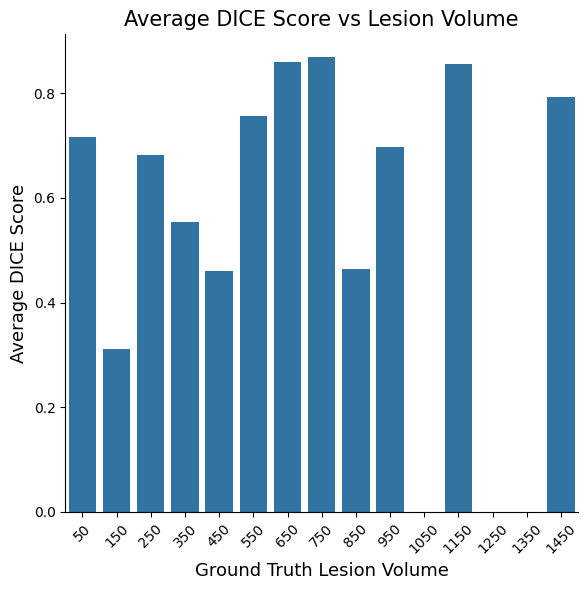

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('dice_scores/segmentation_700.csv').set_index("sample")

# Define custom volume bins
bin_size = 100
bins = range(0, 1600, bin_size)
labels = [f"{bin}-{bin+bin_size}" for bin in bins[:-1]]

# Create bins for the volume
df['volume_bin'] = pd.cut(df['voxel_volume'] * df['label_sum'], bins=bins, labels=labels, right=False)

# Calculate average DICE score for each volume bin
avg_dice_per_volume_bin = df.groupby('volume_bin')['dice_score'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(6, 6))
# sns.set_theme(style="whitegrid", palette="pastel")
sns.barplot(x='volume_bin', y='dice_score', data=avg_dice_per_volume_bin)
plt.xlabel('Ground Truth Lesion Volume', fontsize=13)
plt.ylabel('Average DICE Score', fontsize=13)
plt.title('Average DICE Score vs Lesion Volume', fontsize=15)
plt.xticks(labels, [bin + bin_size // 2 for bin in bins[:-1]], rotation=45)
sns.despine(right=True, top=True)

plt.tight_layout()
plt.savefig("volume_dice.pdf", dpi=100)

/tmp/ipykernel_2419072/3900943935.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_metrics_per_volume_bin = df.groupby('volume_bin')[['dice_score', 'fpv', 'fnv']].mean().reset_index()


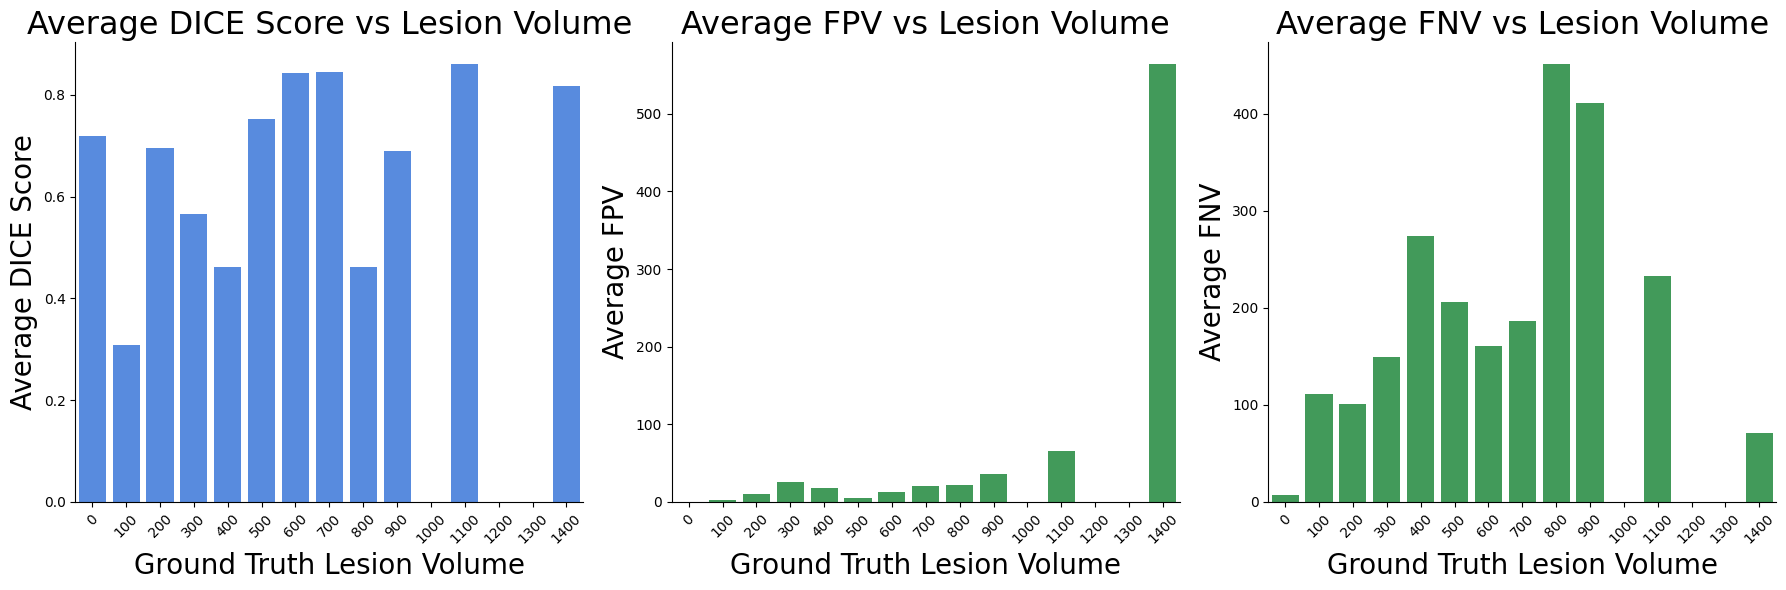

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('dice_scores/reconstructed_r_2.csv').set_index("sample")

# Define custom volume bins
bin_size = 100
bins = range(0, 1600, bin_size)
labels = [f"{bin}-{bin+bin_size}" for bin in bins[:-1]]

# Create bins for the volume
df['volume_bin'] = pd.cut(df['voxel_volume'] * df['label_sum'], bins=bins, labels=labels, right=False)

# Calculate average metrics for each volume bin
avg_metrics_per_volume_bin = df.groupby('volume_bin')[['dice_score', 'fpv', 'fnv']].mean().reset_index()
avg_metrics_per_volume_bin["volume_bin"] = bins[:-1]

# Set up the figure and axes for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Plot Average DICE Score
sns.barplot(x='volume_bin', y='dice_score', data=avg_metrics_per_volume_bin, ax=axes[0], color="#4285F4")
axes[0].set_xlabel('Ground Truth Lesion Volume', fontsize=20)
axes[0].set_ylabel('Average DICE Score', fontsize=20)
axes[0].set_title('Average DICE Score vs Lesion Volume', fontsize=23)

# Plot Average FPV
sns.barplot(x='volume_bin', y='fpv', data=avg_metrics_per_volume_bin, ax=axes[1], color="#34A853")
axes[1].set_xlabel('Ground Truth Lesion Volume', fontsize=20)
axes[1].set_ylabel('Average FPV', fontsize=20)
axes[1].set_title('Average FPV vs Lesion Volume', fontsize=23)

# Plot Average FNV
sns.barplot(x='volume_bin', y='fnv', data=avg_metrics_per_volume_bin, ax=axes[2], color="#34A853")
axes[2].set_xlabel('Ground Truth Lesion Volume', fontsize=20)
axes[2].set_ylabel('Average FNV', fontsize=20)
axes[2].set_title('Average FNV vs Lesion Volume', fontsize=23)

# Adjust x-ticks and remove top and right spines for all plots
for ax in axes:
    # ax.set_xticklabels(labels, rotation=45)
    ax.tick_params(axis='x', labelrotation=45)
    sns.despine(ax=ax, right=True, top=True)

plt.tight_layout()
plt.savefig("volume_metrics.pdf", dpi=100)
plt.show()


/tmp/ipykernel_1775359/316417947.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_metrics_per_volume_bin = df.groupby('volume_bin')[['dice_score', 'fpv', 'fnv']].mean().reset_index()


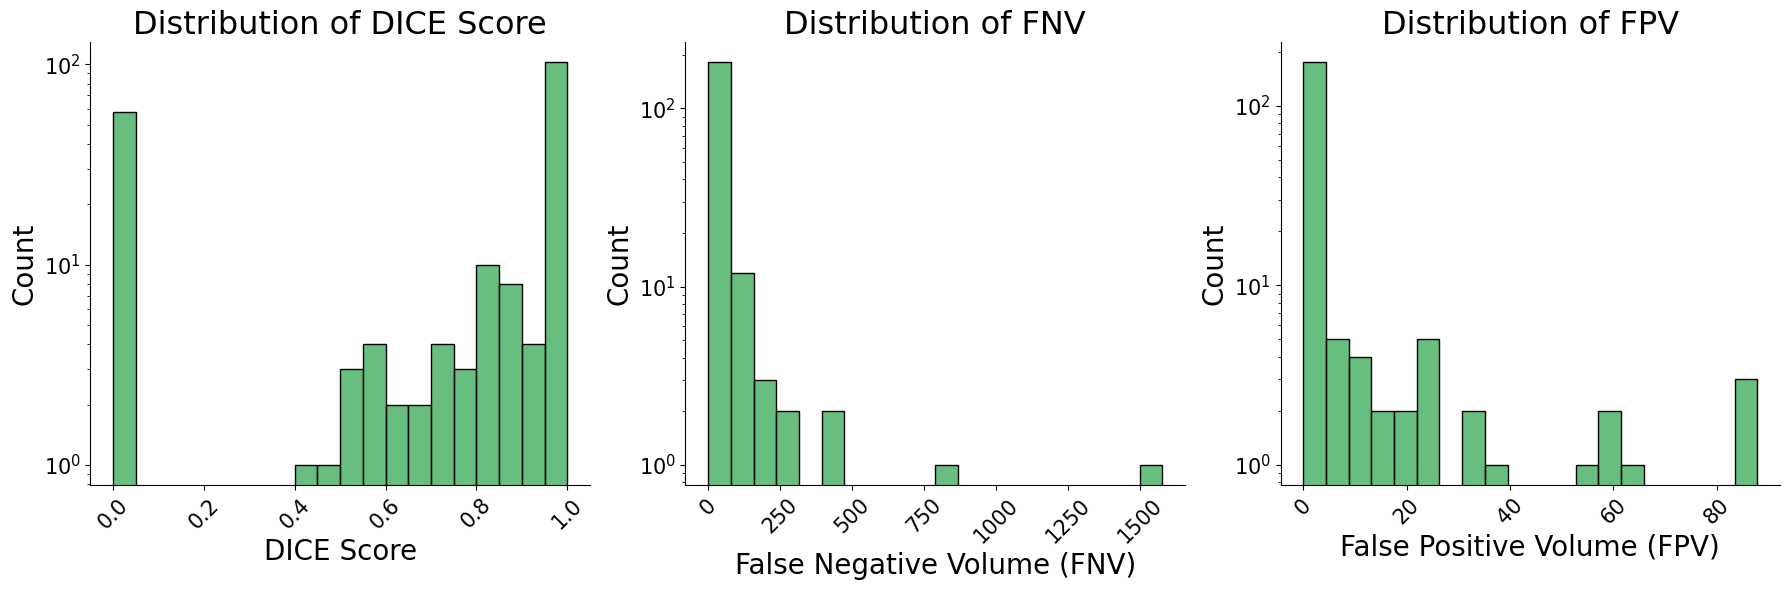

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('dice_scores/corrected_segmentation_700.csv').set_index("sample")

# Define custom volume bins
bin_size = 100
bins = range(0, 1600, bin_size)
labels = [f"{bin}-{bin+bin_size}" for bin in bins[:-1]]

# Create bins for the volume
df['volume_bin'] = pd.cut(df['voxel_volume'] * df['label_sum'], bins=bins, labels=labels, right=False)

# Calculate average metrics for each volume bin
avg_metrics_per_volume_bin = df.groupby('volume_bin')[['dice_score', 'fpv', 'fnv']].mean().reset_index()
avg_metrics_per_volume_bin["volume_bin"] = bins[:-1]

# Set up the figure and axes for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Average DICE Score
# sns.barplot(x='volume_bin', y='dice_score', data=avg_metrics_per_volume_bin, ax=axes[0], color="#4285F4")
# axes[0].set_xlabel('Ground Truth Lesion Volume', fontsize=20)
# axes[0].set_ylabel('Average DICE Score', fontsize=20)
# axes[0].set_title('Average DICE Score vs Lesion Volume', fontsize=23)

# Plot FPV as histplot with percentages
sns.histplot(df, x='dice_score', bins=20, ax=axes[0], color="#34A853")
axes[0].set_xlabel('DICE Score', fontsize=20)
axes[0].set_ylabel('Count', fontsize=20)
axes[0].set_title('Distribution of DICE Score', fontsize=23)
axes[0].set_yscale("log")

# Plot FNV as histplot with percentages
sns.histplot(df, x='fnv', bins=20, ax=axes[1], color="#34A853")
axes[1].set_xlabel('False Negative Volume (FNV)', fontsize=20)
axes[1].set_ylabel('Count', fontsize=20)
axes[1].set_title('Distribution of FNV', fontsize=23)
axes[1].set_yscale("log")

# Plot FPV as histplot with percentages
sns.histplot(df, x='fpv', bins=20, ax=axes[2], color="#34A853")
axes[2].set_xlabel('False Positive Volume (FPV)', fontsize=20)
axes[2].set_ylabel('Count', fontsize=20)
axes[2].set_title('Distribution of FPV', fontsize=23)
axes[2].set_yscale("log")

# Adjust x-ticks and remove top and right spines for all plots
for ax in axes:
    ax.tick_params(axis='x', labelrotation=45, labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    sns.despine(ax=ax, right=True, top=True)

plt.tight_layout()
plt.savefig("volume_metrics_2.pdf", dpi=100)
plt.show()
